In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers



Using TensorFlow backend.


In [2]:

path = 'input/input/'
comp = 'jigsaw-toxic-comment-classification-challenge/'
EMBEDDING_FILE=f'{path}glove.6B.50d.txt'
TRAIN_DATA_FILE=f'{path}train_7.csv'
TEST_DATA_FILE=f'{path}test_3.csv'
FINAL_TEST_DATA_FILE=f'{path}test.csv'

In [3]:


# configuring basic parameters
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use
char_embed_size = 50 # max size of word

In [4]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [5]:

# Read in our data and replace missing values:

train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].values
y_test = test[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values



In [6]:
# Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed)

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))




In [7]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [8]:
# Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))




In [9]:
# Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
print("Mean",emb_mean,"StDiv",emb_std)




c:\users\rusha\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


Mean 0.020940498 StDiv 0.6441043


In [10]:

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
char_embedding_matrix = np.zeros(((nb_words, char_embed_size)))
# print("words not in glove")
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
#     else:
#         print(word)
    vec=np.zeros(char_embed_size)
    word=word[:char_embed_size]
    wc=0
    for c in word:
        vec[wc]=ord(c)/256.0
        wc+=1
    char_embedding_matrix[i]=vec

In [11]:
# Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

inp = Input(shape=(maxlen,))
x = Embedding(max_features, char_embed_size, weights=[char_embedding_matrix])(inp)
# x = Embedding(max_features, embed_size+char_embed_size, weights=[final_embedding_matrix])(inp)

x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# Now we're ready to fit out model! Use validation_split when not submitting.

model.fit(X_train, y_train, batch_size=32, epochs=3, validation_split=0.2);


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 89362 samples, validate on 22341 samples
Epoch 1/3
89362/89362 [==============================] - 815s 9ms/step - loss: 0.0708 - acc: 0.9772 - val_loss: 0.0511 - val_acc: 0.9820
Epoch 2/3
89362/89362 [==============================] - 798s 9ms/step - loss: 0.0467 - acc: 0.9828 - val_loss: 0.0493 - val_acc: 0.9824
Epoch 3/3
89362/89362 [==============================] - 808s 9ms/step - loss: 0.0426 - acc: 0.9840 - val_loss: 0.0509 - val_acc: 0.9822


In [13]:
model.evaluate(x=X_test, y=y_test)

47868/47868 [==============================] - 86s 2ms/step


[0.05067647241062658, 0.9818180414123564]

In [14]:
y_test_pred = model.predict(x=X_test)

In [90]:
y_p = y_test_pred>0.5
y_t = y_test >0


In [114]:
# visualizing what when wrong
for  i in range(len(y_p)):
    if (y_p[i]!=y_test[i]).any():
        print(test[i:i+1])
        print(y_p[i])
        print(y_t[i])

                  id                                       comment_text  \
16  001810bf8c45bf5f  You are gay or antisemmitian? \n\nArchangel WH...   

    toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
16      1             0        1       0       1              1 -0.002799  
[ True False  True False  True False]
[ True False  True False  True  True]
                  id                                       comment_text  \
21  0022cf8467ebc9fd  A Bisexual, like a homosexual or a heterosexua...   

    toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
21      0             0        0       0       0              0  0.670375  
[ True False False False False False]
[False False False False False False]
                  id                                       comment_text  \
28  003217c3eb469ba9  Hi! I am back again!\nLast warning!\nStop undo...   

    toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
28      1      

                   id                                       comment_text  \
320  02a4e52899344a88  MILLINOS OF HUNJAN looking at hunjan template ...   

     toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
320      1             0        0       0       0              0 -1.057508  
[ True False  True False False False]
[ True False False False False False]
                   id                                       comment_text  \
325  02aa3f827a4c7cd6  "\n\n SR/CL: \n\nU bud bin A-way. Like long ti...   

     toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
325      1             0        0       0       0              0  0.617118  
[ True False  True False  True False]
[ True False False False False False]
                   id                                       comment_text  \
342  02cbe8d8e800f936  Where is the real vagina? \n\nThe real photo o...   

     toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
342 

                   id                                      comment_text  \
713  062fa44dc279d3e5  Jon is so smart.  S M R T!  Smart, smart, smart!   

     toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
713      0             0        0       0       0              0 -1.498392  
[ True False False False False False]
[False False False False False False]
                   id                                       comment_text  \
726  065b10e83e654132  User:NHRHS2010 is a homo like mitt romney is. ...   

     toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
726      1             0        1       0       1              1 -0.594465  
[ True False False False  True False]
[ True False  True False  True  True]
                   id                                       comment_text  \
759  069f7c2315031b40  important \n\nyou and your family shall burn! ...   

     toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
759   

                    id                                       comment_text  \
1266  0b0de50dc6cb4029  terrorist \n\nYou seem like a terrorist sir. A...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
1266      1             0        1       0       1              1  0.018682  
[ True False False False False False]
[ True False  True False  True  True]
                    id                                       comment_text  \
1271  0b19454c17bc62f4  LOL; charles, you are a real fag aren't you? s...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
1271      1             0        1       0       1              1  0.678312  
[ True False  True False  True False]
[ True False  True False  True  True]
                    id                                       comment_text  \
1314  0b6d3b57efaf9515  Priest are all pedophiles \nIs this true? How ...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     s

                    id                                       comment_text  \
1789  0fd7d60f23c8b37b  Sure, I'll sign my name on every post I make, ...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
1789      1             0        0       0       0              0  0.133159  
[False False False False False False]
[ True False False False False False]
                    id                                       comment_text  \
1790  0fdaa305356f4129  To Huldra \n\nI sincerely hope you die. 124.18...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
1790      1             0        0       1       0              0 -1.174296  
[ True False False False False False]
[ True False False  True False False]
                    id          comment_text  toxic  severe_toxic  obscene  \
1806  0ff144ce908dfcba  your a fucking bitch      1             1        1   

      threat  insult  identity_hate     split  
1806       0       1 

                    id                                       comment_text  \
2226  1388ee1ed652eca0  You know what, this is bullshit.  Tried to do ...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
2226      1             0        1       0       0              0  0.034527  
[ True False False False False False]
[ True False  True False False False]
                    id                                       comment_text  \
2239  13af43d73330c257  Yarrr! \n\nHeil Hitler, matey!\n\nYou're invit...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
2239      1             0        0       0       0              0 -2.039552  
[False False False False False False]
[ True False False False False False]
                    id                                       comment_text  \
2243  13b3c1d7383707f7  You can add things to my user page, and I am n...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate    sp

                    id                                       comment_text  \
2708  17df2fbc086745c1  I am going to kill you. I am going to murder y...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
2708      1             1        1       1       0              0  1.246921  
[ True False False False  True False]
[ True  True  True  True False False]
                    id                                       comment_text  \
2765  186a35db351539fa  Stop being such a goddamn prick. The article w...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
2765      1             0        1       0       1              0  1.594834  
[ True False False False  True False]
[ True False  True False  True False]
                    id                        comment_text  toxic  \
2770  18736dafe129bfe4  Jimbo Wales is a gay little fucker      1   

      severe_toxic  obscene  threat  insult  identity_hate    split  
2770             

                    id                 comment_text  toxic  severe_toxic  \
3235  1c8efa9eacf4c34c  Are you gay?? Sound like it      1             0   

      obscene  threat  insult  identity_hate     split  
3235        0       0       0              0 -0.537577  
[ True False False False  True False]
[ True False False False False False]
                    id                                       comment_text  \
3238  1c96e8a4e320dfd4  sarah palin is an ass kissing mother fucking l...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
3238      1             1        1       0       1              1  0.606549  
[ True False  True False  True False]
[ True  True  True False  True  True]
                    id                                       comment_text  \
3243  1c9e4583a0be209a  RE HLS \n\nIt is not opinion or theory it has ...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
3243      1             0        0   

                    id                                       comment_text  \
3884  22af7f08f2d3bfc3  "Pashtun Political Party ""Afghan Mellat"" and...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
3884      0             0        0       0       0              0 -0.843557  
[ True False False False False False]
[False False False False False False]
                    id                  comment_text  toxic  severe_toxic  \
3921  22ebd2cb332e6e88  Take your grudges elsewhere.      0             0   

      obscene  threat  insult  identity_hate     split  
3921        0       0       0              0 -0.107158  
[ True False False False False False]
[False False False False False False]
                    id                                       comment_text  \
3926  22f28f593011019e  The Israelis are committing massacres in Gaza,...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
3926      0             0        0 

4341      0             0        0       0       0              0  1.08465  
[ True False False False False False]
[False False False False False False]
                    id                                       comment_text  \
4353  2657c212b4fbce75  "\n\n Doug you're an nobody. You are some old ...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
4353      1             0        1       0       1              0  1.101964  
[ True False False False False False]
[ True False  True False  True False]
                    id                                       comment_text  \
4380  26a1b164a6a502a2  OK YOU. LIKE I SAID THIS IS MY WORLD, I DECIDE...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
4380      1             0        0       0       0              0  0.332577  
[False False False False False False]
[ True False False False False False]
                    id                                       comment_text

                    id                                   comment_text  toxic  \
4819  2a87fe6116dd5766  Neither was your mum, when I had sex with her      1   

      severe_toxic  obscene  threat  insult  identity_hate     split  
4819             0        0       0       1              0 -1.078676  
[ True False False False False False]
[ True False False False  True False]
                    id                                       comment_text  \
4828  2a9996e5b7c27b9a  Hanibal911You're a bastard Pro-Assad. The rebe...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
4828      1             0        1       0       0              0 -0.166712  
[ True False  True False  True False]
[ True False  True False False False]
                    id                                       comment_text  \
4855  2ac487f44d704445  Warning \n\nPlease stop. If you continue being...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
4

5213      1             0        1       1       1              1  0.379098  
[ True False  True False False False]
[ True False  True  True  True  True]
                    id                                       comment_text  \
5216  2e0f60bf77130180  Shit \n\nGeorge tan031993 you're a bitch!!!\n\...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
5216      1             1        1       0       1              0  1.283651  
[ True False  True False  True False]
[ True  True  True False  True False]
                    id                                       comment_text  \
5224  2e26f4d6a494a19d  " the verifibility policy. I don't know. 13 ot...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
5224      1             0        1       0       0              0 -0.467903  
[ True False False False False False]
[ True False  True False False False]
                    id                                       comment_tex

                    id                                       comment_text  \
5500  3087e0f43bc60391  warning for doing nothing?\n\nFC*K U\n\nWhy th...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
5500      1             0        1       0       0              0  0.07123  
[False False False False False False]
[ True False  True False False False]
                    id                                       comment_text  \
5501  3088bf20bdacda12  well then don't \n\nundo other people's edits ...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
5501      0             0        0       0       0              0 -0.188717  
[ True False  True False False False]
[False False False False False False]
                    id                                       comment_text  \
5508  3090e571cf51e36a  You needsa worka on your mannersa!\nI noticed ...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     spl

[ True False  True False  True  True]
                    id                                       comment_text  \
5878  340ef39887a2709f  ":I have painstakingly taken the time to scan ...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
5878      1             0        0       0       0              0  0.257598  
[False False False False False False]
[ True False False False False False]
                    id                                       comment_text  \
5920  3461594302e934ab  "\nP.S.: regarding the word ""orthodox"", a wo...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
5920      0             0        0       0       0              0 -0.105002  
[ True False False False False False]
[False False False False False False]
                    id                                       comment_text  \
5921  3461caa53a47e231  and i will make as many sockpuppets as I like!...   

      toxic  severe_toxic  obscen

                    id                                       comment_text  \
6249  3731c09a908ffde7  F u c k i n g   c u n t s get a life you sad f...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
6249      1             1        1       0       1              1 -0.014312  
[ True False  True False  True False]
[ True  True  True False  True  True]
                    id                                       comment_text  \
6257  3746b3d6ac243dee  U ANNOYIN BIITCH.. WHY U KEEP ON REVERTIN WAT ...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
6257      1             1        1       0       1              1  0.777229  
[ True False  True False  True False]
[ True  True  True False  True  True]
                    id                                       comment_text  \
6286  3791b29f022da0f2  It comes from a desire to become a Wikipedia a...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     s

                    id                                      comment_text  \
6724  3b9d648ed9053bb7  Please have a look at Wikipedia:Dick, thank you.   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
6724      0             0        0       0       0              0  0.109132  
[ True False  True False False False]
[False False False False False False]
                    id                                       comment_text  \
6737  3bc62c560e766445  What the hell is wrong with this thing ? why a...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
6737      1             0        0       0       0              0  0.799275  
[False False False False False False]
[ True False False False False False]
                    id                 comment_text  toxic  severe_toxic  \
6749  3bd9c797d7d2a25f  I think chelski are crap!!!      1             0   

      obscene  threat  insult  identity_hate     split  
6749        1     

[ True False  True False False False]
[ True False False False False False]
                    id                                       comment_text  \
7245  4034b3f9c6050f6b  "\n\n ""Swallow that cum!"" Removed \n\n""Fema...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
7245      1             0        1       0       0              0 -0.379999  
[False False False False False False]
[ True False  True False False False]
                    id                                       comment_text  \
7257  4053f1f27e115abf  Where do you get off deleting that? it took me...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
7257      1             0        1       0       1              1  0.147584  
[ True False  True False  True False]
[ True False  True False  True  True]
                    id                                       comment_text  \
7262  405bda134182afc4  "\n\nThis article is ludicrous, it paints anti...

7755      1             0        1       0       0              0  0.246469  
[False False False False False False]
[ True False  True False False False]
                    id                                       comment_text  \
7756  44d0f0b1dfe09e3f  Get Off My Talk Page U Troublemakers.  Buzz Of...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
7756      0             0        0       0       0              0  0.409001  
[ True False False False False False]
[False False False False False False]
                    id                                       comment_text  \
7764  44d8a1aad4973721  Hot4\nMy Ryan, do come back to me you gorgeous...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
7764      1             0        0       0       0              0 -0.597515  
[ True False  True False  True False]
[ True False False False False False]
                    id                                       comment_tex

                    id                                       comment_text  \
8165  487aae50e403889c  I realize from Wnt's message on Virgin birth (...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
8165      1             0        0       0       0              0 -0.549116  
[False False False False False False]
[ True False False False False False]
                    id                                       comment_text  \
8168  4880d1db35040b1e  I can't remember the last time I contributed c...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
8168      0             0        0       0       0              0  0.916198  
[ True False False False False False]
[False False False False False False]
                    id                                       comment_text  \
8181  48a52cf370bc47c9  Portia Gibbons?? \n\nWho was the idiot that in...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     s

                    id                                       comment_text  \
8542  4bc3f8babbb247b5  So he forgot to change his signature. Don't go...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
8542      1             0        0       0       0              0 -1.317953  
[False False False False False False]
[ True False False False False False]
                    id                                       comment_text  \
8581  4c1b817ee7d2cb7d  Msg for Vandalisim? \n\nWhy am I getting this ...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
8581      1             0        1       0       0              0 -0.468113  
[ True False  True False  True False]
[ True False  True False False False]
                    id                        comment_text  toxic  \
8585  4c238430f3575853  JUST SMOEK WEEED TWICE AS HARD!!!!      1   

      severe_toxic  obscene  threat  insult  identity_hate     split  
8585            

                    id                                       comment_text  \
8907  4efa858ca91d25f3  yo \n\nwat u chng it for, kutcher is prick and...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
8907      1             0        1       0       1              1 -0.237661  
[ True False  True False  True False]
[ True False  True False  True  True]
                    id                                       comment_text  \
8910  4f07198d77000ae1  YOU DIRTY FUCKIGN NIGGER. STOP DELETEING MY WO...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
8910      1             0        1       0       1              1  0.054957  
[ True False  True False  True False]
[ True False  True False  True  True]
                    id                                       comment_text  \
8916  4f197b83741cc6c8  by the way\nthis is a university computer.. so...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     s

                    id                                       comment_text  \
9396  533f21ea9bf4315b  IS A FASCIST BULLY CONSTANTLY ATTEMPTING TO FO...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
9396      1             1        1       0       1              1 -0.140591  
[ True False  True False  True False]
[ True  True  True False  True  True]
                    id                                       comment_text  \
9443  53a8091d23ddb68e  You downplay Catholic Holocausts \n\nYou prete...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
9443      0             0        0       0       0              0  0.681384  
[ True False False False False False]
[False False False False False False]
                    id                                       comment_text  \
9444  53aaa6e86ea1a4be  FUCK YOU ! \n\nFUCK YOU ! BITCH, ILL SHOW UR G...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     s

                    id                                       comment_text  \
9876  57d9f06d48f1d4a6  What a retard, that . Shut your FUD up, you ar...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
9876      1             0        0       0       1              0 -0.639298  
[ True False False False False False]
[ True False False False  True False]
                    id                                       comment_text  \
9877  57da14fd7e6f3e74  "\n\nGamaliel, I think you over-reacted.  The ...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
9877      0             0        0       0       0              0 -0.06938  
[ True False False False False False]
[False False False False False False]
                    id                                       comment_text  \
9893  57f5972ab8910562  "\n\nLook there are clearly more ""people"" he...   

      toxic  severe_toxic  obscene  threat  insult  identity_hate     spl

                     id                                       comment_text  \
10260  5b9e9cf3c7facd14  Okay retard whatever you say have fun being a ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
10260      1             0        0       0       1              0 -2.064926  
[ True False False False False False]
[ True False False False  True False]
                     id                                       comment_text  \
10283  5be21e25bd1664e1  "\n\nBaby Got Back Section?\nOh my god\nBecky,...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
10283      1             0        0       0       0              0  0.168734  
[False False False False False False]
[ True False False False False False]
                     id                         comment_text  toxic  \
10292  5bf0426bbc551699  I Have A Tight Asshole And Hate Fun      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
102

[ True False False False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
10748  601e6b2351edfecb  Gleisinger Corporation \n\npiss off and do som...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
10748      0             0        0       0       0              0 -0.983733  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
10772  6054c535f5827ba7  What the hell \nI just edited my entry you mor...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
10772      1             0        1       0       1              0  1.637567  
[ True False False False  True False]
[ True False  True False  True False]
                     id                                       comment_text  \
10775  6059d86641decf92  THE TRUE IS TAIWAN IS A COUNTRY ,CHINA 

                     id                                       comment_text  \
11163  63c62e371750895e  This all goes to prove how EASILY manipulated ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
11163      1             0        0       0       0              0 -0.187762  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
11169  63d2f529eae987c2  "\n\n""This is not a forum. And you (81.154.20...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
11169      1             0        0       0       0              0  0.726372  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
11177  63e060595875d224  Adam4267 again \n\nNo Drmias I'm not dumb. I'm...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id             comment_text  toxic  severe_toxic  \
11635  67ccf286e16c38db  Butt face idiot friends      1             0   

       obscene  threat  insult  identity_hate     split  
11635        0       0       1              0  0.827395  
[ True False  True False  True False]
[ True False False False  True False]
                     id                                       comment_text  \
11649  67e8c11251117aab  I cited some more sources in my new edits. I h...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
11649      0             0        0       0       0              0 -1.989558  
[ True False False False False False]
[False False False False False False]
                     id                                     comment_text  \
11650  67eb3dd3398f7c8f  I still dont know what the hell I did Assholes!   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
11650      1             0        1   

                     id                                       comment_text  \
12147  6c1ea1e6513eef48  It's got nothing to do with race, it's got eve...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
12147      1             0        0       0       0              0 -1.378929  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
12163  6c45b41e8dee8f9d  Some jackass vandalized the article again, can...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
12163      1             0        1       0       1              0 -0.145041  
[ True False False False False False]
[ True False  True False  True False]
                     id                comment_text  toxic  severe_toxic  \
12167  6c4fb8ff6a2979b6  hello \n\nyou are a nigger      1             0   

       obscene  threat  insult  identity_hate     split  
12167  

                     id                                       comment_text  \
12650  70a6b61c56ec32f2  little girl \n\nstop deleting my stuff why don...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
12650      1             0        0       0       0              0  0.660281  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
12667  70c395b9492c4ab9  I'm ignoring all the rules. That's a wikipedia...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
12667      1             0        0       0       0              0 -0.562937  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
12672  70d69f3c1e6ff9d8  BKBKBKBK\nlease take some time to review our s...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
13007  73b32ede5358a264  Just putting a bitch in HIS place. Do you did ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
13007      1             0        1       0       0              0  0.018832  
[ True False  True False  True False]
[ True False  True False False False]
                     id                                       comment_text  \
13010  73b6084f980815b5  Thanks\nThanks for participating in the conspi...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
13010      1             0        0       0       0              0  1.067721  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
13017  73c462e6b5fc8a07  "\n\n Wah wah wah \nThe ""authority"" rises to...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
13522  787518a78ae15691  And you should also wait for people to tell wh...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
13522      0             0        0       0       0              0  1.213628  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
13533  788f0ac8d02f15c5  massage for scum==\n Đoković will smash your b...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
13533      1             0        0       0       0              0 -1.441518  
[ True False  True False  True False]
[ True False False False False False]
                     id                                       comment_text  \
13538  789aec3018a3cc63  WHO CARES ABOUT A BUNCH OF DIRTY MONKEYS FROM ...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
13883  7b83413e4b225df4  User:Edgar181 is a shit.\nUser:Edgar181 is a s...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
13883      1             0        1       0       1              0  1.712053  
[ True False  True False False False]
[ True False  True False  True False]
                     id                            comment_text  toxic  \
13888  7b8c82823c742a57  Shut up. I'm going to rape your sister      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
13888             0        1       1       1              0  0.150645  
[ True False False False  True False]
[ True False  True  True  True False]
                     id                                       comment_text  \
13902  7ba73d7587ca3568  I have noticed that underneath Sexuality on th...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
1390

                     id                                       comment_text  \
14421  800576c2ac915848  Another moron who thinks it's below him to do ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
14421      1             0        1       0       1              0 -0.162419  
[ True False False False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
14441  803109343a9b79b8  78.101.161.86   \n\nBEEEITCH ANNA LIKES TO SUK...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
14441      1             0        1       0       1              0  0.941091  
[ True False False False False False]
[ True False  True False  True False]
                     id                             comment_text  toxic  \
14456  8047b626391903e6  This article sucks \n\nwoo woo wooooooo      1   

       severe_toxic  obscene  threat  insult  identity_hate     spl

                     id                                       comment_text  \
14974  8543e525c0fe5368  I know how frustrated you are right now. Stupi...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
14974      0             0        0       0       0              0  0.303442  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
14979  854d4eeef87967b2  Yo\n\nGuy was a bastard but let's not fake quo...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
14979      1             0        0       0       0              0 -0.586025  
[ True False  True False  True False]
[ True False False False False False]
                     id                                       comment_text  \
14980  854df6634e25d6d1  no friends. I spread my legs for money. I work...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
15479  89e532b85ed98af6  One last thing... \n\nYou are a thundercunt of...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
15479      0             0        0       0       0              0 -1.749373  
[ True False False False False False]
[False False False False False False]
                     id           comment_text  toxic  severe_toxic  obscene  \
15480  89e709fa4a5fb710  retarded spastic head      1             0        0   

       threat  insult  identity_hate     split  
15480       0       1              0 -0.888496  
[ True False False False False False]
[ True False False False  True False]
                     id                                       comment_text  \
15496  8a0bd9eeebef2cc3  "\n\nedit:\nOk, forget it, I am honored by thi...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
15496      1             0        0   

16046      1             0        1       0       1              0  1.533998  
[ True False  True False False False]
[ True False  True False  True False]
                     id                     comment_text  toxic  severe_toxic  \
16059  8f37752bc4f348e1  Fuck you \n\ny\n\n76.67.105.188      1             0   

       obscene  threat  insult  identity_hate     split  
16059        1       0       0              0 -0.813003  
[ True False  True False  True False]
[ True False  True False False False]
                     id                    comment_text  toxic  severe_toxic  \
16064  8f4418f1a58ba052  Ged UK, just shut UP!  Omnigan      1             0   

       obscene  threat  insult  identity_hate     split  
16064        0       0       0              0 -0.186361  
[ True False  True False False False]
[ True False False False False False]
                     id                                       comment_text  \
16066  8f449b8ab17e2f39  PRICK\nFIRE THIS ADMINISTRATOR!!\n

                     id                       comment_text  toxic  \
16512  934512b5ece8a059  Fuck you The Anome, Porn for you.      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
16512             0        1       0       0              0  1.340746  
[ True False  True False  True False]
[ True False  True False False False]
                     id                                       comment_text  \
16523  935c8baf5bba1b08  'What makes you think I give a fuck about your...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
16523      0             0        1       0       0              0 -0.749168  
[ True False  True False False False]
[False False  True False False False]
                     id                                       comment_text  \
16564  93db5f4e3c9cba21  Mel Etitis, Are you retarded? \n\nWhat is your...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
16564      1  

                     id                                       comment_text  \
16950  972c9edd5c31439b  I don't have a vendetta you little piece of sh...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
16950      1             0        0       0       0              0  0.343729  
[ True False  True False  True False]
[ True False False False False False]
                     id                                       comment_text  \
16998  978dca9521f3422c  Faerie's Aire and Death Waltz \n\nHi. Just tho...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
16998      1             0        0       0       0              0 -1.349294  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
17022  97da1f499e159bc6  you both \n\nare little faggots with no lives ...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
17323  9aa1f7cd52019270  why are you so miserable  \n\nand keep blockin...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
17323      0             0        1       0       1              0  0.629837  
[ True False False False  True False]
[False False  True False  True False]
                     id                                       comment_text  \
17324  9aa6196a4e6dc846  Thanks for making the hypocrisy of your edits ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
17324      1             0        0       0       0              0  0.182951  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
17335  9ac8f127709e4289  That IP banning is working great, keep up the ...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
17858  9f60176c387e05a1  So sorry copy and paste this to 10 articles or...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
17858      1             0        0       1       0              0 -0.909103  
[False False False False False False]
[ True False False  True False False]
                     id                                       comment_text  \
17861  9f677cb5d3a49260  Your persistence in making personal threats is...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
17861      1             0        0       0       0              0  0.20244  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
17870  9f74dbc9f7064b0c  die \n\nplease why dont u do us all a favioe a...   

       toxic  severe_toxic  obscene  threat  insult  identity_h

                     id                                       comment_text  \
18303  a35a2ec237020c8c  btw there needs to be some serious fact checki...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
18303      0             0        0       0       0              0  1.128139  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
18315  a37d83646c34f883  "Nobody's could be called homophobic, even emp...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
18315      1             0        1       0       0              0  0.29317  
[ True False  True False  True False]
[ True False  True False False False]
                     id                                       comment_text  \
18323  a3859735ed4f433d  "\n\nthis is stupid. i defent the actions of U...   

       toxic  severe_toxic  obscene  threat  insult  identity_h

                     id                                       comment_text  \
18885  a8837ed85131a354  Another ridiculous article by WikiPedia ==\n\n...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
18885      1             0        0       0       0              0  1.260061  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
18908  a8b14ec0632e7df9  I actually have aspergers as well but ive lear...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
18908      1             0        1       0       1              0  0.304917  
[ True False False False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
18914  a8c0c22da9328590  Will you lot frikking stop it \n\nUse any fook...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
19300  ac3b410d526f94b4  You represent the BOTTOM OF THE BARREL at Wiki...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
19300      1             0        0       0       1              0 -0.541152  
[False False False False False False]
[ True False False False  True False]
                     id                                       comment_text  \
19330  ac83e4ee5106e593  boring prick  \n\nget off bobby zamora's page ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
19330      0             0        0       0       0              0  0.40191  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
19338  ac94a57dd393f9d6  Todd and Copper\nIn the first film they were l...   

       toxic  severe_toxic  obscene  threat  insult  identity_h

                     id                                       comment_text  \
19806  b0ac50e69d765224  TWAT \n\nyour a fucking twat mosh u fucking li...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
19806      1             1        1       0       1              0  1.244694  
[ True False  True False  True False]
[ True  True  True False  True False]
                     id                                       comment_text  \
19822  b0c2f728af3e46d5  Beraian\n\ninstead of giving other people a ha...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
19822      1             0        0       0       0              0  0.358142  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
19827  b0cb480bf62834d5  YOU'RE THE DISEASE OF AMERICA\nSTEALING JOBS F...   

       toxic  severe_toxic  obscene  threat  insult  identity

20336      1             0        1       0       1              0 -0.726089  
[ True False False False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
20366  b58d7832bf1a5e5b  FUCK U DENNIS BURN IN HELL YOU SON OF A BITCH ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
20366      1             1        1       0       1              0  0.753741  
[ True False  True False  True False]
[ True  True  True False  True False]
                     id                                       comment_text  \
20368  b5986bca54227a44  wikipedia.org for my fans i leave for one seco...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
20368      1             0        0       0       0              0 -1.427703  
[False False False False False False]
[ True False False False False False]
                     id                                       c

                     id                                       comment_text  \
20807  b977b36ff0aba246  "\n\n KITTENS! \n\nI throw them against the wa...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
20807      1             0        0       0       0              0  0.955422  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
20819  b9880f30b82ae219  Wrestling with a pig \n\nWell, you know what t...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
20819      1             0        0       0       1              0 -1.37107  
[False False False False False False]
[ True False False False  True False]
                     id                                       comment_text  \
20832  b99d571270e3697a  IT IS UNNATURAL FOR A MAN TO TAKE ANOTHER MAN'...   

       toxic  severe_toxic  obscene  threat  insult  identity_h

                     id                                       comment_text  \
21298  be0cdab4cbd7a85d  yo will i am sorry \n\nwill i would like to ap...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
21298      1             0        1       0       1              1 -1.437677  
[ True False  True False  True False]
[ True False  True False  True  True]
                     id                                       comment_text  \
21311  be3a6e32a31dc910  A Message to You Allie\nOh HAI, cockmonkey n!g...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
21311      1             0        1       0       1              1  0.310442  
[ True False False False False False]
[ True False  True False  True  True]
                     id              comment_text  toxic  severe_toxic  \
21322  be597a8fe20072f0  You ARE \n\nmeany pants!      1             0   

       obscene  threat  insult  identity_hate     split  
21322      

21679      1             0        0       0       0              0  0.06506  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
21690  c1743b03e8fe47ab  "OOOOHHHH With a big long Intellectually Terri...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
21690      1             0        0       0       0              0  0.185099  
[False False False False False False]
[ True False False False False False]
                     id                          comment_text  toxic  \
21699  c185145cdf371bca  yea soooo  ur stupidd!!!!!!!!! loser      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
21699             0        1       0       1              0 -0.570947  
[ True False False False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
21706  c19a4

                     id                                       comment_text  \
22120  c533fd97d7dd92e3  Mass Murder \nTAB \nChe Guevara was a mass mur...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
22120      1             0        0       0       1              0  0.004888  
[ True False False False False False]
[ True False False False  True False]
                     id                                       comment_text  \
22124  c53d8d5abaada677  You stupid, you are so damn follish. And the B...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate   split  
22124      1             0        1       0       1              0  0.0238  
[ True False False False  True False]
[ True False  True False  True False]
                     id                                       comment_text  \
22125  c53e65f907aaef20  for what. i never personally attacked anyone h...   

       toxic  severe_toxic  obscene  threat  insult  identity_hat

                     id                                       comment_text  \
22608  c93b7b4a19f0c4b8  "\n\n Kike \n\ndammit baba!  leave it alone!  ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
22608      0             0        1       0       1              0  0.167174  
[False False False False False False]
[False False  True False  True False]
                     id                                comment_text  toxic  \
22633  c95ce3ea131e6813  your mum know's nothin bout chechoslovakia      0   

       severe_toxic  obscene  threat  insult  identity_hate     split  
22633             0        0       0       0              0 -0.805023  
[ True False False False  True False]
[False False False False False False]
                     id                          comment_text  toxic  \
22637  c968308e5acc14af  rude \n\nso you are gay then!!!!!!!!      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
22637          

                     id                                       comment_text  \
23029  cd066fd33f04d2d8  What kind of freak keeps obsessive stalkerish ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
23029      0             0        0       0       1              0  1.431511  
[ True False False False False False]
[False False False False  True False]
                     id                                       comment_text  \
23034  cd135d9358a9e9ea  DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FA...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
23034      1             0        0       0       0              0 -0.99805  
[ True  True  True False  True False]
[ True False False False False False]
                     id                  comment_text  toxic  severe_toxic  \
23040  cd2573e7f05d05b1  Hi! \n\nHow come you're gay?      1             0   

       obscene  threat  insult  identity_hate     split  
23040

23414      1             0        0       0       1              0 -0.18881  
[ True False False False False False]
[ True False False False  True False]
                     id                                       comment_text  \
23415  d08dd59a46b758fe  "\nNo, you were complaining about Landon's civ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
23415      1             0        0       0       0              0  0.001392  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
23421  d09b4a2b701a04dd  You horrid little shit \n\nI've been monitorin...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
23421      1             0        1       0       1              0  0.968243  
[ True False False False False False]
[ True False  True False  True False]
                     id                                       co

                     id                                       comment_text  \
23858  d456d780b7c7e063  "\nI beg to differ. His edit summary clearly s...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
23858      0             0        0       0       0              0  1.302797  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
23870  d472b35e0c0c8297  Go fuk your mom you fukin faggot.  I'll commit...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
23870      1             1        1       0       1              1  2.406873  
[ True False  True False  True False]
[ True  True  True False  True  True]
                     id                                       comment_text  \
23884  d48a5ca967762203  you stupied crack head u need to get a life an...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
24381  d9106bb9f1dfb95c  "\n\nYOU PROMOTES RACISM, IT IS NOT VANDALISM....   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
24381      1             0        0       0       0              0  1.159827  
[False False False False False False]
[ True False False False False False]
                     id                                 comment_text  toxic  \
24382  d917b445427660da  next tiem you spam my site i kick your asss      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
24382             0        1       0       0              0 -0.433294  
[False False False False False False]
[ True False  True False False False]
                     id                                       comment_text  \
24385  d91f22bcfd6610a9  Monella (film)\nDo whatever you want with it f...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     sp

                     id                                       comment_text  \
24804  dceaa1e3b99b778f  Honestly, I don't mind \n\nAn that fact that y...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
24804      1             0        0       0       1              1  0.162328  
[ True False False False False False]
[ True False False False  True  True]
                     id                                       comment_text  \
24816  dd0967b21fee6329  "\nHEHHEHHEHE!!!  Another ABSOLUTELY CLASSIC V...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
24816      1             0        0       0       0              0 -0.256703  
[ True False  True False  True False]
[ True False False False False False]
                     id                                       comment_text  \
24863  dd8a5db49f32452e  Dear Greenman,\n\nAs usual you have proven to ...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
25341  e1fa0ea5b9e7c6c7  HE OR SHE IS ACCUSIN ME OF SHIT I DIDNT DO Y N...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
25341      1             0        1       0       0              0  0.113365  
[ True False  True False  True False]
[ True False  True False False False]
                     id                                       comment_text  \
25358  e21bca55de5692e2  Did you read the user attack\nDid you actually...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
25358      0             0        1       0       0              0  1.258551  
[False False False False False False]
[False False  True False False False]
                     id                                       comment_text  \
25364  e2365dc810639224  THIS SITUSH GUY IS MESSING UP THIS ARTICLE ON ...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
25766  e5587990989b8fb3  Wow, Rhymeless isn't such a jerk.  He can spel...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
25766      1             0        0       0       1              0  1.50649  
[ True False False False False False]
[ True False False False  True False]
                     id                                       comment_text  \
25779  e57eaed440919bc3  MuZemike \n\nalso MuZemike is a dirty little f...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
25779      1             1        1       0       1              1 -0.884785  
[ True False  True False  True False]
[ True  True  True False  True  True]
                     id                                       comment_text  \
25796  e5a60e7d2ce682ab  Are u serious? Those idiots are just a bunch o...   

       toxic  severe_toxic  obscene  threat  insult  identity_h

                     id                                       comment_text  \
26190  e90346bf9e09529e  Fool! \n3RR\nPlease refrain from undoing other...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
26190      1             0        0       1       0              0 -0.879946  
[False False False False False False]
[ True False False  True False False]
                     id                                       comment_text  \
26231  e975e4d626e610cb  Go fuck yourself and stop contacting me.  I ne...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
26231      1             1        1       0       1              0 -1.145121  
[ True False  True False  True False]
[ True  True  True False  True False]
                     id                                       comment_text  \
26239  e9976adfd109e154  "\n\n Go fuck yourself \n\n""and the creator i...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
26599  ecf6701bdac3352e  Faggot \n\nGo fuck McGreevy's loose asshole yo...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
26599      1             0        1       0       1              0  1.002989  
[ True  True  True False  True False]
[ True False  True False  True False]
                     id                                       comment_text  \
26600  ecf6c6d0acd1f87e  No one is vandalizing assholes, so get it stra...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
26600      1             0        1       0       1              0  0.210214  
[ True False  True False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
26628  ed394c0fb50ff4bc  Fuck you too\nThanks for blocking me... but yo...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
27115  f19bc7ab70fd1fe7  stop pretending as if you are the owner of tha...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
27115      1             0        0       0       0              0 -0.545432  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
27137  f1d7893688a3e334  i anal rape little iraqie children while i typ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
27137      1             1        1       0       1              1  1.449861  
[ True False  True False  True False]
[ True  True  True False  True  True]
                     id                                   comment_text  toxic  \
27148  f1e268f885410864  don't by silly \n\nthis is your final warning      0   

       severe_toxic  obscene  threat  insult  identity_

27626      1             1        1       0       1              0 -0.536263  
[ True False  True False  True False]
[ True  True  True False  True False]
                     id                                       comment_text  \
27634  f5a0d65a0b36e1e0  HEY TELLY FUCK YOU TOO.  Can't you morons unde...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
27634      1             1        1       0       1              0  2.262601  
[ True False  True False  True False]
[ True  True  True False  True False]
                     id                                       comment_text  \
27652  f5c8e9af04906789  The name of an ignorant person is . So many ti...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
27652      0             0        0       0       0              0 -0.733493  
[ True False False False False False]
[False False False False False False]
                     id                                       c

                     id                                       comment_text  \
28218  fafe1c7039c629ca  STOP EDITING MY POSTS DIPSHIT \nI HAVE A RIGHT...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
28218      1             0        1       0       0              0  0.755938  
[ True False  True False  True False]
[ True False  True False False False]
                     id                                       comment_text  \
28236  fb305d31413f368a  "Dbachmann, you are a motherfuckin' sonofabitc...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
28236      1             1        1       0       1              1  0.960258  
[ True False  True False  True False]
[ True  True  True False  True  True]
                     id                                       comment_text  \
28271  fb71a182b65fddd2  If this were true, then the Welsh would all be...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
28748  ffd0fcf25070ec11  Still a coward\n\nReverting me doesn't revert ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
28748      0             0        0       0       1              0 -0.569706  
[ True False False False False False]
[False False False False  True False]
                     id                                       comment_text  \
28751  ffd4c3511073d2ba  Are you an Idiot Mr Caribbean H.Q.? \n\nWhy ar...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
28751      1             0        0       0       1              0  1.286123  
[False False False False False False]
[ True False False False  True False]
                     id                                       comment_text  \
28763  fff43d83e83d53d6  ":::What do you mean, ""mind your language""? ...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
29158  0797d292f447d922  MONGO SAD\n\n   + Please don't use any pages t...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
29158      1             0        1       0       0              0  0.563481  
[ True False  True False  True False]
[ True False  True False False False]
                     id                             comment_text  toxic  \
29163  07acf2c033452d0f  kids incorporated \n\nSHUT THE HELL UP.      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
29163             0        1       0       0              0  0.110503  
[ True False False False False False]
[ True False  True False False False]
                     id                                       comment_text  \
29168  07b813902f37b1d4  Homos on Wikipedia \n\nHi Chris! Thanks for be...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
29

                     id                                       comment_text  \
29659  101fc6b19d55dd9f  "\n\n Different rules for different people \n\...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
29659      1             0        1       0       0              0  0.091886  
[ True False False False False False]
[ True False  True False False False]
                     id                                       comment_text  \
29665  10385dc75ce526cd  Haunted Angel you will pay for this when you g...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
29665      0             0        0       0       0              0  0.224864  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
29667  1044fdda817c4534  Can you read? \n\nOr are you one of those moro...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
30088  17c348e2e2bd45da  How do you get semen stains off jeans?\nHow do...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
30088      1             0        0       0       0              0  0.317031  
[ True False False False  True False]
[ True False False False False False]
                     id                                       comment_text  \
30103  18003369687cfebf  Fanatics on Wikipedia\nDo you dispute the fact...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
30103      0             0        1       0       0              0  0.338612  
[ True False False False False False]
[False False  True False False False]
                     id                                       comment_text  \
30110  181dac51783614cd  {{unblock| because i was accused of editin som...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
30478  1eb50fb9e1d3abe7  My stuff \n\nYou reported me due to articles? ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
30478      1             0        0       0       0              0  0.093106  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
30481  1ec645e199a530fa  May I also add that you're a cock and you shou...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
30481      0             0        1       0       1              0 -1.969506  
[ True False  True False  True False]
[False False  True False  True False]
                     id                                       comment_text  \
30518  1f70fbfe3d15724c  How Stupid Are You?\nOnce again you have shown...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id             comment_text  toxic  severe_toxic  \
30988  27b9c4d51468d4e6  she is a little lesbian      1             0   

       obscene  threat  insult  identity_hate     split  
30988        0       0       1              1 -0.371445  
[ True False False False False False]
[ True False False False  True  True]
                     id                                       comment_text  \
30993  27d4775b80ab5d16  I REPRESTNE A DRIECT THREATH TO THIS STIE YOU ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
30993      1             0        0       0       0              0 -0.054685  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
30997  27edac837ee913bc  "   Sooooo... Does any OTHER admin want to com...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
30997      0             0        

                     id                                       comment_text  \
31389  2f0d19f295fc17d9  Aliens, birtherism, and other conspiracy theor...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
31389      0             0        0       0       0              0  0.189828  
[ True False False False False False]
[False False False False False False]
                     id                                    comment_text  \
31398  2f2d66f0c8f8f987  Suck it bitch!!!!!!! \n\nha ha bitch fuck!!!!!   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
31398      1             1        1       0       1              0  1.354852  
[ True False  True False  True False]
[ True  True  True False  True False]
                     id                             comment_text  toxic  \
31419  2f8fd6dc677a0b8c  yeh well ban me fukkers fuck you morons      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
3

                     id                                       comment_text  \
31989  399cc39f2103573d  wants to commit suicide because everyone on Wi...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
31989      0             0        0       0       0              0 -0.623567  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
32023  3a090db8c5ce1d41  This article sucks \n\nI would nominate it for...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
32023      1             0        0       0       0              0 -0.08074  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
32035  3a432f42b99ab249  You know what I think? I think you should take...   

       toxic  severe_toxic  obscene  threat  insult  identity_h

                     id                                       comment_text  \
32411  4044a63abeb6b739  "\nGanging up to exclude a new editor is not "...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
32411      0             0        0       0       0              0  1.005051  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
32412  4044e0935dc8888b  "\n\nReggie Jackson?\nI think you are mistakin...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
32412      1             0        0       0       0              0  1.744842  
[ True False False False  True False]
[ True False False False False False]
                     id                                       comment_text  \
32416  4064b0f9618ebd11  "FUCK YOU ME ETITIS ♣   Chat wit' me  §  Contr...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
32844  48864bf47139797c  Duel \n\nI challenge you to a duel. I will be ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
32844      0             0        0       0       0              0  2.163399  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
32854  48ad17b15723e6ae  Don't piss mme off!\n\n'I MEEN IT YOU DLEATED ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
32854      1             0        1       0       1              0  1.076522  
[ True False False False False False]
[ True False  True False  True False]
                     id                          comment_text  toxic  \
32859  48c24e87ece0ecdb  Lucasbfr: your mother is a cock slut      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
3

                     id                    comment_text  toxic  severe_toxic  \
33306  511d04c7d4d40c45  Hitler, The Game\nYou lost it.      0             0   

       obscene  threat  insult  identity_hate     split  
33306        0       0       0              0  0.074781  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
33313  513fe416036a82bc  You aren't freaks or bastards, by the way. I r...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
33313      0             0        0       0       0              0  1.077529  
[ True False  True False  True False]
[False False False False False False]
                     id                                       comment_text  \
33328  5195fdc1ca02d9b7  Delete \nDELETE THE FUCKING IMAGES AND STOP SE...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
33328      1        

                     id                                       comment_text  \
33890  5b490762e7927369  Well looky who just got blocked again? You are...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
33890      0             0        0       0       0              0 -0.457055  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
33900  5b7e85f9e2899dc4  |decline=Ignorance is never an excuse. I sugge...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
33900      1             0        0       0       0              0  0.187061  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
33916  5bc4f5947d80d4d9  OH SHUT UP!! You are just a stupid hateful lib...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
34329  6332a4fa17317543  "GET A LIFE DHASS HOLE!== \nFinding articles 1...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
34329      1             0        0       0       0              0 -0.084285  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
34336  6341677727415e2d  This always happens by all these unregistered ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
34336      0             0        0       0       1              0 -0.190818  
[ True False False False False False]
[False False False False  True False]
                     id                                       comment_text  \
34345  6370f37abcf50c41  Go fuckin' hang yourself! Fuckin' scum of the ...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
34899  6d07c3c4e1c7b2f9  Dennis Bratland is a homophob british bastard ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
34899      1             0        0       0       1              1 -0.70523  
[ True False  True False  True False]
[ True False False False  True  True]
                     id                                       comment_text  \
34901  6d111bcce2dd33c9  I was reverted the page, a vandal erase the co...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
34901      0             0        0       0       0              0  0.578229  
[ True False False False False False]
[False False False False False False]
                     id                                   comment_text  toxic  \
34926  6d84ad02916a1563  hey \n\nyour a gay nigger mother fucking cunt      1   

       severe_toxic  obscene  threat  insult  identity_ha

                     id             comment_text  toxic  severe_toxic  \
35432  766997bfc92e84cc  I hate you? I hate you!      1             0   

       obscene  threat  insult  identity_hate     split  
35432        0       0       0              0  1.408898  
[ True False False False  True False]
[ True False False False False False]
                     id                                       comment_text  \
35451  770b051b2da69566  little douchebag... \n\n...you gonna wish you ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
35451      1             0        0       0       1              0 -0.524589  
[ True False False False False False]
[ True False False False  True False]
                     id                                       comment_text  \
35455  771fe0179399abe0  All external links are supposed to follow Wiki...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
35455      1             0        

35987      0             0        1       0       0              0  0.393668  
[False False False False False False]
[False False  True False False False]
                     id                                       comment_text  \
36021  82b5aed7526148df  !!! FUCK YOU, SLAKR!!!\n\nDIE WIKIPEDIA DIE WI...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
36021      1             1        1       1       1              0 -0.116255  
[ True False  True False  True False]
[ True  True  True  True  True False]
                     id                    comment_text  toxic  severe_toxic  \
36022  82b693d02df5ec5a  Let my article on retard!!!}:(      0             0   

       obscene  threat  insult  identity_hate     split  
36022        0       0       1              0  0.049578  
[ True False False False False False]
[False False False False  True False]
                     id                                       comment_text  \
36023  82b7de837004ae71

                     id            comment_text  toxic  severe_toxic  obscene  \
36414  8987458f1a951ed1  ura fag... \n\nu gay L      1             0        0   

       threat  insult  identity_hate     split  
36414       0       0              0  0.118787  
[ True False  True False  True False]
[ True False False False False False]
                     id                                       comment_text  \
36420  8996d52950c0ca4e  A POEM ABOUT ABE DASHIEL: THIS IS WHAT YOU ARE...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
36420      1             0        0       0       1              1 -2.456123  
[ True False False False False False]
[ True False False False  True  True]
                     id                                       comment_text  \
36449  8a15bc67790faeb9  "\nIt's not that you ""didn't manage the prope...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
36449      1             0        0 

                     id                                       comment_text  \
36824  908b347bfd7c9bb6  I'ma smack ya upside da head wit a shovel. \n\...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
36824      0             0        0       1       0              0  1.24264  
[ True False False False False False]
[False False False  True False False]
                     id                   comment_text  toxic  severe_toxic  \
36826  9099e3407a364874  Are you a man.....or a woman?      0             0   

       obscene  threat  insult  identity_hate     split  
36826        0       0       0              0  0.330731  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
36841  90d2dbf3ca3d33b9  God says is enough!\nI know you and Russian fa...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
36841      0             

                     id                                       comment_text  \
37240  975908e45e69282e  Roisterer is a prime example of why this place...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
37240      1             0        0       0       0              0  0.019019  
[False False False False False False]
[ True False False False False False]
                     id                                     comment_text  \
37257  9799523f3d835f8e  Wikinazis are attacking my talk page! Nooo!!! -   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
37257      1             0        0       0       0              0 -0.320019  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
37260  97a153ca8307abb5  "I fail to see the relevance of the reference ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hat

                     id                                       comment_text  \
37637  9e488b5834db8cca  Call it being pushed into a corner or call it ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
37637      1             0        1       0       1              0  1.224348  
[ True False  True False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
37641  9e50a5cc11ef3cce  You Are A Douche \n\nWhy the hell are you pick...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
37641      1             0        1       0       1              0  1.353316  
[ True False False False  True False]
[ True False  True False  True False]
                     id                                       comment_text  \
37643  9e6b70e0db26315b  A misery=\nYou have made my life a misery on W...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
38178  a7d87b2706e2a3a3  Stalking \nI asked you to stop bothering me.  ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
38178      0             0        0       0       0              0  0.402646  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
38197  a82eea39b49bb446  go fcuk youslef \n\nI am going to kill you thi...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
38197      1             0        1       1       1              0 -2.875634  
[ True False False False  True False]
[ True False  True  True  True False]
                     id                                       comment_text  \
38226  a89e3823c7bdf951  oops I didn't request a new IP from dhcp, anyw...   

       toxic  severe_toxic  obscene  threat  insult  identity

[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
38667  b091ecddae1654ff  =Dear Mr ANAL Retentive...\nWTF are you talkin...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
38667      1             0        1       0       1              0 -2.310848  
[ True False  True False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
38669  b09f3611d3eae7b3  I think KFCazure is a 13 your old, probably be...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
38669      0             0        0       0       0              0  0.130967  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
38688  b0f11a65fbc54c44  I can tell you that in Baghdadthe shit 

                     id                                       comment_text  \
39222  bb1d26724ca5868e  EkoGraf - EK728 \n\nSince them deleted my earl...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
39222      1             0        0       0       0              0 -0.172402  
[False False False False False False]
[ True False False False False False]
                     id                      comment_text  toxic  \
39231  bb355215de78e74a  you are a gay anti-hindu bastard      1   

       severe_toxic  obscene  threat  insult  identity_hate    split  
39231             1        1       0       1              1  0.22907  
[ True False  True False  True False]
[ True  True  True False  True  True]
                     id                                       comment_text  \
39254  bba58adc00948854  to emarsee \nI appologize, though I think you ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
39254      0      

39533      1             0        0       0       1              0  0.692215  
[ True False  True False  True False]
[ True False False False  True False]
                     id                                       comment_text  \
39537  c0dfdd5e3004c9ab  "\n\n  Are you fing kidding me? There are 30+ ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
39537      1             0        0       0       0              0  0.088101  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
39538  c0e076f0011acaa6  "FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
39538      1             1        1       0       1              0  0.53343  
[ True False  True False  True False]
[ True  True  True False  True False]
                     id                                       com

                     id                                       comment_text  \
40047  c9ee25227958cc1b  you dirty dirty hypocrite - there you are lect...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
40047      1             0        0       0       1              0 -0.089832  
[ True False  True False  True False]
[ True False False False  True False]
                     id                           comment_text  toxic  \
40049  c9f1a6522fc800d8  fuck you asshole 69.47.197.27  Geku25      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
40049             1        1       0       1              0 -0.549054  
[ True False  True False  True False]
[ True  True  True False  True False]
                     id                                       comment_text  \
40055  ca0136a0cfdd1628  See you in two days. \n\nHahahaha. You protect...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
40055 

                     id                                       comment_text  \
40454  d0f127ee06e3289c  "\n\nHi\n\nNo, I am a Khalsa. I feel sorry for...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
40454      0             0        0       0       0              0 -0.964932  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
40455  d0f292817862c8e2  Thanks for blocking me. I called Tao an idiot ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
40455      1             0        1       0       1              0 -0.146139  
[False False False False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
40500  d1c8d5b954d7800a  PHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OF...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                   comment_text  toxic  severe_toxic  \
41054  dba09aefdc18b182  hey hey hey runescape players      0             0   

       obscene  threat  insult  identity_hate    split  
41054        0       0       0              0  0.30795  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
41056  dba7d46f3cc858b7  "\nLOL! Sorry Jayron, i just saw your message ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
41056      1             0        0       0       0              0 -1.027623  
[ True False  True False False False]
[ True False False False False False]
                     id                                       comment_text  \
41115  dca2adad76fc640c  you're a douche... it is not a slang guide it ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
41115      1            

41477      1             1        1       0       1              1 -1.327339  
[ True  True  True False  True False]
[ True  True  True False  True  True]
                     id                                       comment_text  \
41486  e34101f638fc1d63  Your impending death \n\nBecause of your libel...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
41486      1             0        0       1       0              0 -1.442043  
[False False False False False False]
[ True False False  True False False]
                     id                                       comment_text  \
41499  e38046b316967ddb  "\n\nOh haha, very witty. I like the fact that...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
41499      1             0        0       0       0              0 -1.095669  
[False False False False False False]
[ True False False False False False]
                     id                                       c

                     id                comment_text  toxic  severe_toxic  \
41960  ec13fcfebe109add  Vagina \nThis user has one      1             0   

       obscene  threat  insult  identity_hate     split  
41960        0       0       0              0  0.712766  
[ True False  True False False False]
[ True False False False False False]
                     id                                       comment_text  \
41963  ec22f9997f3a367d  ok \n\ni am NOT trying to piss you off ,but do...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
41963      0             0        0       0       0              0  0.072017  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
41973  ec47907fc000df7c  hello \n\nI would like to draw your attention ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
41973      1             0  

[ True  True  True False  True  True]
                     id                                       comment_text  \
42416  f47c5a9884f2c75f  User:Legacypac is the most evil wikipedian in ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
42416      1             0        0       0       0              0 -0.210933  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
42417  f481c6dc4afa059f  Cheap caste fanatic Jonathan. NBK Wiki page va...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
42417      1             0        0       0       0              0  1.489929  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
42437  f4f313dfb3bf7703  Re \n\nHi, just thought I'd let you know that ...   

       toxic  severe_to

                     id                                       comment_text  \
42839  fc1409ce15ed124a  If this is how you show you are polite, excuse...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
42839      0             0        0       0       0              0  0.212456  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
42840  fc1cd8e3864be0e7  Verbal must be stopped \n\nAnything you can do...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
42840      1             0        0       0       1              0  0.036537  
[ True False False False False False]
[ True False False False  True False]
                     id                     comment_text  toxic  severe_toxic  \
42869  fcba1fca56fc3cf9  NawlinWiki, that is disgusting.      1             0   

       obscene  threat  insult  identity_hate     split

                     id                                       comment_text  \
43414  1154e8e807e235d2  =This Article is Terrible\n\nHonestly, one of ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
43414      1             0        0       0       0              0 -0.263616  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
43423  1184b426177b8ff8  Hello,sorry to waste you're time \n\nhello, so...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
43423      1             0        0       0       0              0  1.026956  
[ True False  True False  True False]
[ True False False False False False]
                     id                                       comment_text  \
43434  11f66f5616c690ab  U are a bitch nigga. Fuck u and the guy who bl...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
43835  259b5e751d71c61e  read what I say and understand my meaning - if...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
43835      1             0        1       0       1              0 -1.189474  
[ True False  True False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
43849  26484136969d618e  SBC-YBR is an idiot who reverts things without...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
43849      1             0        1       0       1              0  0.391138  
[ True False False False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
43852  269ca53d1a88c1f6  "\n\n Why did Vladimir Putin kill them all? \n...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
44362  40f1aad06068e680  Deaf culture is full of a bunch of jerks \nWho...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
44362      1             0        0       0       1              1 -0.323883  
[ True False False False False False]
[ True False False False  True  True]
                     id                                       comment_text  \
44373  421010b18bfd1899  Just To Let You Know. You have no life.\nI hat...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
44373      1             0        0       0       0              0 -0.138616  
[ True False  True False  True False]
[ True False False False False False]
                     id                comment_text  toxic  severe_toxic  \
44385  42ec189f6902c0e4  freakofnuture can suck it!      1             0   

       obscene  threat  insult  identity_hate     split  
44385  

                     id                                       comment_text  \
44712  545204ea92089fa1  Arrogant\n\nStating your full name and all of ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
44712      1             0        0       0       0              0 -0.346234  
[ True False  True False  True False]
[ True False False False False False]
                     id                       comment_text  toxic  \
44722  54b35d3772958680  is anyone there? HELLO? MOM??????      0   

       severe_toxic  obscene  threat  insult  identity_hate     split  
44722             0        0       0       0              0 -0.182126  
[ True False False False False False]
[False False False False False False]
                     id                                       comment_text  \
44727  54ef213e7e311c0b  Should we not just refer to them as Blacks? Af...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
44727      1  

                     id                                       comment_text  \
45123  6b4a8d5f0415cd4d  FUCK YOU YOU FUCKING FAGGOT!!!! this is Sean M...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
45123      1             1        1       0       1              1 -0.550451  
[ True False  True False  True False]
[ True  True  True False  True  True]
                     id                               comment_text  toxic  \
45130  6b7d867e013deb5d  I'm Kissing up \n\nI want to kiss you ass      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
45130             0        1       0       0              0  2.734187  
[ True False  True False  True False]
[ True False  True False False False]
                     id                                       comment_text  \
45131  6bae49bf2757e767  I have nothing better to do than sit at my com...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split 

                     id                                       comment_text  \
45637  890db12df368a8a0  Welcome Faggot!\n\nWelcome!\n\nHello, , and we...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
45637      1             0        1       0       1              0 -1.634594  
[False False False False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
45644  893f3c7aad05b2c3  Admin killed research material. Lost taste. fr...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
45644      1             0        0       0       0              0  1.147879  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
45669  8adf8133ecb9c3b2  "\n\nScarcity of sources ? the same jewish pap...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                       comment_text  \
46079  a0cede3d652030d1  "\n""Somebody, go write one.""  Do it yourself...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
46079      1             0        0       0       0              0 -0.967607  
[False False False False False False]
[ True False False False False False]
                     id                                  comment_text  toxic  \
46081  a118ed5d8c3242a8  bite me \n\nthat is all.  cunt198.111.56.230      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
46081             0        0       0       0              0  0.239682  
[False False False False False False]
[ True False False False False False]
                     id           comment_text  toxic  severe_toxic  obscene  \
46090  a1b3582a7426e5fd  Your obedient servant      0             0        0   

       threat  insult  identity_hate     split  
46090       0     

                     id                                       comment_text  \
46460  b74ad4527aa8f08e  "\n\n Bishonen \n\nSo are you his lackey or ju...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
46460      1             0        1       0       1              0 -0.275463  
[ True False False False False False]
[ True False  True False  True False]
                     id                                       comment_text  \
46474  b7c6f39554dd5ee9  opinion/origin \n\nIt is my opinion that lip s...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate    split  
46474      1             0        0       0       0              0  0.04197  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
46480  b7eb5d6be93a2a7a  , 19 April 2009 (UTC)\nStay out of it damn it,...   

       toxic  severe_toxic  obscene  threat  insult  identity_h

                     id                                       comment_text  \
46965  cf2c9523705a64b6  "\n\n Stalker? \n\n""Just because you're paran...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
46965      1             0        1       0       0              0 -2.379944  
[ True False False False False False]
[ True False  True False False False]
                     id                                       comment_text  \
46972  cf7253d3d7fbae4e  Perhaps this idiot should explain first why he...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
46972      1             0        0       0       1              0  1.496559  
[False False False False False False]
[ True False False False  True False]
                     id                                       comment_text  \
47000  d11d8e373683c4f1  now that he's blocked me so that I can't respo...   

       toxic  severe_toxic  obscene  threat  insult  identity

                     id                                comment_text  toxic  \
47335  e368a3264e71d56e  So many children to abuse - so little time      1   

       severe_toxic  obscene  threat  insult  identity_hate     split  
47335             0        0       0       0              0 -0.034576  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
47344  e446a8c48101739c  You must be a sock. Your request was your only...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     split  
47344      1             0        0       0       0              0 -0.658018  
[False False False False False False]
[ True False False False False False]
                     id                                       comment_text  \
47358  e53547de91817f52  What, I never agreed with you. You clearly kno...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate     spli

In [123]:
FINAL_TEST_DATA_FILE=f'{path}test.csv'
final_test = pd.read_csv(FINAL_TEST_DATA_FILE)
list_tokenized_final_test = final_test["comment_text"].fillna("_na_").values
list_tokenized_final_test = tokenizer.texts_to_sequences(list_tokenized_final_test)
X_final_test = pad_sequences(list_tokenized_final_test, maxlen=maxlen)

(153164, 6)

In [125]:
y_final = model.predict(X_final_test)



In [126]:


sample_submission = pd.read_csv(f'{path}sample_submission.csv')

sample_submission[list_classes] = y_final



sample_submission.to_csv("submission.csv", index=False)

In [106]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total para

In [107]:
model.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

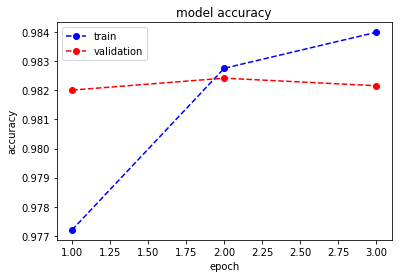

In [110]:
import matplotlib.pyplot as plt
A = range(1,len(model.history.history['acc'])+1)
B = [ round(i,5) for i in model.history.history['acc']]
C = [ round(i,5) for i in model.history.history['val_acc']]

plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# for xy in zip(A, B):                                       # <--
#     plt.annotate('TRN(%s, %s)' % xy, xy=xy, textcoords='data') # <--
# for xy in zip(A, C):                                       # <--
#     plt.annotate('TST(%s, %s)' % xy, xy=xy, textcoords='data') # <--

plt.legend(['train', 'validation'], loc='upper left')
plt.show()

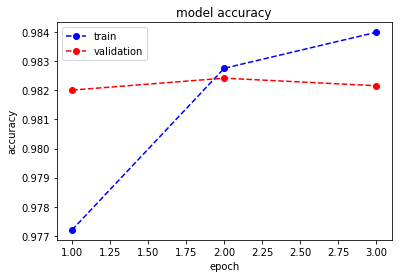

In [111]:
A = range(1,len(model.history.history['acc'])+1)
B = [ round(i,5) for i in model.history.history['acc']]
C = [ round(i,5) for i in model.history.history['val_acc']]
plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# for xy in zip(A, B):                                       # <--
#     plt.annotate('TRN(%s, %s)' % xy, xy=xy, textcoords='data') # <--
# for xy in zip(A, C):                                       # <--
#     plt.annotate('TST(%s, %s)' % xy, xy=xy, textcoords='data') # <--

plt.legend(['train', 'validation'], loc='upper left')
plt.show()

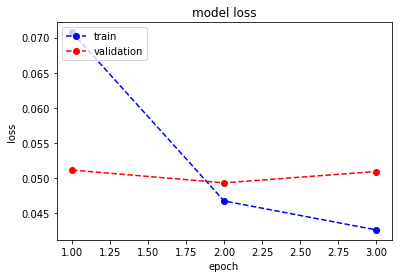

In [112]:
A = range(1,len(model.history.history['loss'])+1)
B = model.history.history['loss']
C = model.history.history['val_loss']
plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
def sample_test(S1,model):
    v=tokenizer.texts_to_sequences([S1])
    v=pad_sequences(v,maxlen=maxlen)
    y=list(model.predict([v], batch_size=1024, verbose=1))
    for i in range(6):
        print(y[0][i], list_classes[i])